# Maximization bias

In [3]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

# The Problem
In this problem, there are two states, A and B. In state A, there are two actions, right and left. The right action transitions to the terminal state with a reward of 0. The left action transitions to state B, where there are 10 actions. Nine of these actions transition to the terminal state with a reward drawn from a normal distribution with mean -0.1 and variance 1. Episodes always start in state A. The discount factor is 1. The value of all states and actions is initialized to 0. The step size is 0.1. The epsilon value for the epsilon-greedy policy is 0.1. The algorithm used is Q-learning. **The optimal policy is to always take the right action in state A** and the action with the highest value in state B. The optimal policy achieves a reward of 0.05 per episode. However, **maximization bias causes the Q-learning algorithm to choose the left action in state A more often than the optimal policy**. This is because the Q-learning algorithm overestimates the value of the left action in state A. **The double Q-learning algorithm is used to mitigate this maximization bias**. The double Q-learning algorithm uses two sets of Q-values to estimate the value of each action. The algorithm randomly selects one of the two sets of Q-values to estimate the value of each action. The algorithm then uses the other set of Q-values to select the action with the highest value.

In [4]:
# state A
STATE_A = 0

# state B
STATE_B = 1

# use one terminal state
STATE_TERMINAL = 2

# starts from state A
STATE_START = STATE_A

# possible actions in A
ACTION_A_RIGHT = 0
ACTION_A_LEFT = 1

# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.1

# discount for max value
GAMMA = 1.0

# possible actions in B, maybe 10 actions
ACTIONS_B = range(0, 10)

# all possible actions
STATE_ACTIONS = [[ACTION_A_RIGHT, ACTION_A_LEFT], ACTIONS_B]

# state action pair values, if a state is a terminal state, then the value is always 0
INITIAL_Q = [np.zeros(2), np.zeros(len(ACTIONS_B)), np.zeros(1)]

# set up destination for each state and each action
TRANSITION = [[STATE_TERMINAL, STATE_B], [STATE_TERMINAL] * len(ACTIONS_B)]

In [5]:
# choose an action based on epsilon greedy algorithm
def choose_action(state, q_value):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(STATE_ACTIONS[state])
    else:
        values_ = q_value[state]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

# take @action in @state, return the reward
def take_action(state, action):
    if state == STATE_A:
        return 0
    return np.random.normal(-0.1, 1)


def q_learning(q1, q2=None):
    """
    Q-Learning algorithm:  if there are two state action pair value array, use double Q-Learning
    otherwise use normal Q-Learning
    :param q1: q value 1
    :param q2: q value 2
    :return: left count
    """       
    state = STATE_START
    # track the # of action left in state A
    left_count = 0
    while state != STATE_TERMINAL:
        if q2 is None:
            action = choose_action(state, q1)
        else:
            # derive an action from Q1 and Q2
            action = choose_action(state, [item1 + item2 for item1, item2 in zip(q1, q2)])
        if state == STATE_A and action == ACTION_A_LEFT:
            left_count += 1
        reward = take_action(state, action)
        next_state = TRANSITION[state][action]
        if q2 is None:
            active_q = q1
            target = np.max(active_q[next_state])
        else: # Double Q-Learning  
            if np.random.binomial(1, 0.5) == 1:  # randomly choose the active Q value
                active_q = q1
                target_q = q2
            else:
                active_q = q2
                target_q = q1
            best_action = np.random.choice([action_ for action_, value_ in enumerate(active_q[next_state]) if value_ == np.max(active_q[next_state])])
            target = target_q[next_state][best_action]

        # Q-Learning update
        active_q[state][action] += ALPHA * (
            reward + GAMMA * target - active_q[state][action])
        state = next_state
    return left_count

100%|██████████| 1000/1000 [00:48<00:00, 20.43it/s]


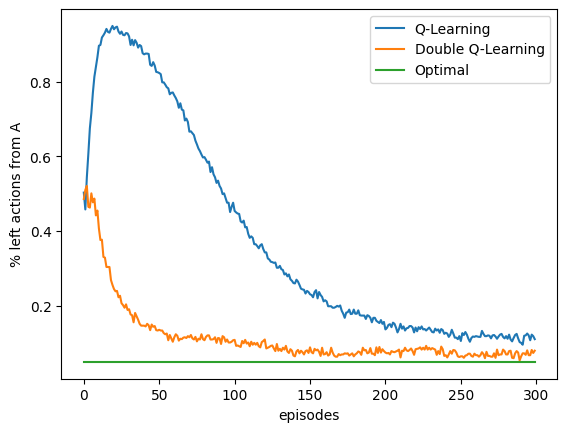

In [6]:
# Figure 6.7, 1,000 runs may be enough, # of actions in state B will also affect the curves
def figure_6_7():
    # each independent run has 300 episodes
    episodes = 300
    runs = 1000
    left_counts_q = np.zeros((runs, episodes))
    left_counts_double_q = np.zeros((runs, episodes))
    for run in tqdm(range(runs)):
        q = copy.deepcopy(INITIAL_Q)
        q1 = copy.deepcopy(INITIAL_Q)
        q2 = copy.deepcopy(INITIAL_Q)
        for ep in range(0, episodes):
            left_counts_q[run, ep] = q_learning(q)
            left_counts_double_q[run, ep] = q_learning(q1, q2)
    left_counts_q = left_counts_q.mean(axis=0)
    left_counts_double_q = left_counts_double_q.mean(axis=0)

    plt.plot(left_counts_q, label='Q-Learning')
    plt.plot(left_counts_double_q, label='Double Q-Learning')
    plt.plot(np.ones(episodes) * 0.05, label='Optimal')
    plt.xlabel('episodes')
    plt.ylabel('% left actions from A')
    plt.legend()

    plt.plot()

figure_6_7()

### Exercise 6.13
Modify the code above to have the updates the Q-values using the Double Expected Sarsa algorithm. The Double Expected Sarsa algorithm is given by:
$$Q_1(S_t, A_t) = Q_1(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \sum_a \pi_2(a\mid S_{t+1}) \cdot Q_1(S_{t+1}, a)  - Q_1(S_t, A_t) \right]$$
$$Q_2(S_t, A_t) = Q_2(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \sum_a \pi_1(a\mid S_{t+1}) \cdot Q_2(S_{t+1}, a)  - Q_2(S_t, A_t) \right]$$
where $\pi_i(a\mid S_{t+1})$ is the probability of selecting action $a$ in state $S_{t+1}$ using the policy derived from $Q_i$. 

